# Planet Labs Kaggle Competition

https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/submit

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from planet import *

In [39]:
torch.cuda.set_device(0)

In [40]:
PATH = Path("data/planet")
sz = 224
arch = resnet34
bs = 58

In [41]:
label_csv = PATH/"train_v2.csv"
n = len(list(open(label_csv))) - 1
validation_idxs = get_cv_idxs(n) # default - save 20% for validation

In [42]:
!ls {PATH}

models			  test-jpg-additional	    train-jpg
sample_submission_v2.csv  test_v2_file_mapping.csv  train_v2.csv
test-jpg		  tmp


In [43]:
label_df = pd.read_csv(label_csv)

In [44]:
label_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [45]:
# how to group on individual tags instead of combination?
# label_df.pivot_table(index='tags', aggfunc=len).sort_values('image_name', ascending=False)

# Data augmentation

In [46]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 
                                    folder='train-jpg', 
                                    test_name='test-jpg',
                                    val_idxs=validation_idxs,
                                    csv_fname=label_csv, 
                                    bs=bs, 
                                    tfms=tfms, 
                                    suffix='.jpg')
    return data

In [47]:
data=get_data(sz, bs)

In [48]:
learn = ConvLearner.pretrained(arch, data, metrics=[f2])

In [49]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [50]:
i = 5
fn = PATH/data.trn_ds.fnames[i]; print(fn)
cl = data.trn_ds.get_y(i); 
print(np.array(data.classes)[np.where(cl)[0]])

data/planet/train-jpg/train_8.jpg
['agriculture' 'clear' 'cultivation' 'primary']


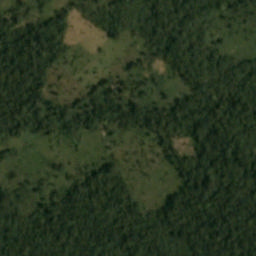

In [51]:
img = PIL.Image.open(fn).convert('RGB'); img

In [52]:
img.size

(256, 256)

# Find learning rate

In [53]:
lrf = learn.lr_find()

epoch      trn_loss   val_loss   f2                          
    0      0.221245   0.477688   0.832241  



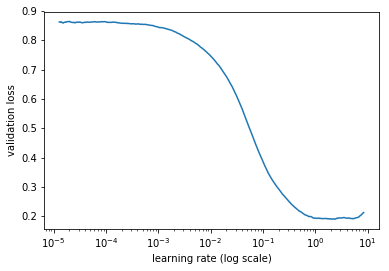

In [54]:
learn.sched.plot()

In [55]:
lr = 0.2

# Train on small images

In [58]:
data = get_data(64, bs)
learn = ConvLearner.pretrained(arch, data, metrics=[f2])

In [59]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.149565   0.130334   0.88672   
    1      0.141571   0.125741   0.891321                    
    2      0.136474   0.122957   0.894546                    
    3      0.139775   0.122322   0.893675                    
    4      0.134072   0.120334   0.895949                    
    5      0.132183   0.118705   0.897628                    
    6      0.127056   0.118381   0.89835                     



[array([0.11838]), 0.8983503041169515]

In [60]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.132568   0.118893   0.897492  
    1      0.128657   0.118224   0.898942                    
    2      0.130079   0.117406   0.898511                    



[array([0.11741]), 0.8985108588434777]

In [62]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   f2                          
    0      0.127547   0.116493   0.900078  
    1      0.130107   0.116061   0.899801                    
    2      0.128428   0.115955   0.90066                     



[array([0.11595]), 0.9006600959350901]

In [63]:
learn.save('64-frozen');
learn.load('64-frozen');

# Unfreeze to train earlier layers

In [64]:
lrs = [lr/9, lr/3, lr]
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.116455   0.103206   0.914326  
    1      0.110716   0.099199   0.917218                    
    2      0.103053   0.096349   0.919525                    
    3      0.10974    0.099519   0.916698                    
    4      0.103801   0.095747   0.920328                     
    5      0.10063    0.094285   0.918883                     
    6      0.097943   0.093131   0.922351                     



[array([0.09313]), 0.9223507182273981]

In [69]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

    1      0.098581   0.094108   0.919912                     
    2      0.093694   0.09229    0.923299                     
    3      0.096836   0.094515   0.921356                     
    4      0.093942   0.093091   0.920806                     
    5      0.094278   0.091605   0.922537                     
  2%|▏         | 13/559 [00:03<01:54,  4.75it/s, loss=0.0928]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [70]:
learn.save('64-unfrozen');
learn.load('64-unfrozen');

# Train on larger data

In [71]:
learn.set_data(get_data(128, bs))

learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.095425   0.092184   0.920689  
    1      0.097906   0.090983   0.922479                     
    2      0.09235    0.090919   0.922572                     
    3      0.094728   0.090909   0.922746                     
    4      0.091431   0.09061    0.922481                     
    5      0.089235   0.090077   0.923502                     
 16%|█▌        | 87/559 [00:10<01:03,  7.49it/s, loss=0.0936]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [72]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.093227   0.085021   0.928568  
    1      0.092124   0.085967   0.928129                     
    2      0.085105   0.083302   0.930723                     
    3      0.091021   0.086495   0.929579                     
 66%|██████▌   | 367/559 [01:57<00:57,  3.33it/s, loss=0.0859]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [77]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.084313   0.084001   0.929278  
    1      0.086961   0.085052   0.931557                     
    2      0.080237   0.083185   0.930902                     
    3      0.086876   0.086116   0.928238                     
    4      0.082673   0.084785   0.930004                     
    5      0.079233   0.084296   0.930395                     
    6      0.075436   0.084806   0.930014                     



[array([0.08481]), 0.930013640719592]

In [73]:
learn.save('128-frozen');
learn.load('128-frozen');